## Activate Robot Car Obstacle Avoidance

#### Import Libraries and log info

#### Functions Block

In [1]:
#!/usr/bin/python3
#coding=utf8
import sys
sys.path.append('/home/pi/work/notebooks') # cutom version of TurboPI
import cv2
import time
import math
import signal
import threading
import numpy as np
import pandas as pd
from IPython import display
from PIL import Image
from time import sleep
import sys

import FCSRSDK.yaml_handle as yaml_handle
import FCSRSDK.FCSRCamera as Camera
import FCSRSDK.FCSRSonar as Sonar
import FCSRSDK.FCSRBoard as Board
import FCSRSDK.FCSRMecanumChassis as mecanum

if sys.version_info.major == 2:
    print('Please run this program with python3!')
    sys.exit(0)

    
print('''
**********************************************************
******** BUSH FCSR Robot Car Avoidance Test **********
**********************************************************
----------------------------------------------------------
FCSR website:https://chandrunarayan.github.io/fcsr
----------------------------------------------------------
Tips:
 * Press ctrl-c or stop button to exit
----------------------------------------------------------
''')


**********************************************************
******** BUSH FCSR Robot Car Avoidance Test **********
**********************************************************
----------------------------------------------------------
FCSR website:https://chandrunarayan.github.io/fcsr
----------------------------------------------------------
Tips:
 * Press ctrl-c or stop button to exit
----------------------------------------------------------



#### MAIN Block
MAIN Block



In [2]:

car = mecanum.MecanumChassis()

def initMove():
    global debug
    
    car.set_velocity(0,90,0,debug) 
    if debug: 
        print("debug car.set_velocity(0,90,0)") #reset
    servo_data = yaml_handle.get_yaml_data(yaml_handle.servo_file_path)
    servo1 = servo_data['servo1']
    servo2 = servo_data['servo2']
    Board.setPWMServoPulse(1, servo1, 200)
    Board.setPWMServoPulse(2, servo2, 200)


def reset():
    global debug
    global turn
    global speed
    global forward
    global distance
    global old_speed
    global Threshold
    global stopMotor
    global __isRunning
    
    speed = 60
    old_speed = 0
    distance = 9999
    Threshold = 50.0
    turn = True
    forward = True
    stopMotor = True
    __isRunning = False
    

def init():
    print("Avoidance Init")
    initMove()
    reset()
    
__isRunning = False

def start():
    global debug
    global __isRunning
    global stopMotor
    global forward
    global turn
    
    turn = True
    forward = True
    stopMotor = True
    __isRunning = True
    print("Avoidance Start")


def stop():
    global debug
    global __isRunning
    
    __isRunning = False
    
    car.set_velocity(0,90,0,debug) 
    if debug: 
        print("debug car.set_velocity(0,90,0)") #reset
    time.sleep(0.3)
    print("Avoidance Stop")


def exit():
    global debug
    global __isRunning
    
    __isRunning = False
    car.set_velocity(0,90,0,debug) 
    if debug: 
        print("debug car.set_velocity(0,90,0)") #reset
    time.sleep(0.3) 
    HWSONAR.setPixelColor(0, Board.PixelColor(0, 0, 0))
    HWSONAR.setPixelColor(1, Board.PixelColor(0, 0, 0))
    print("Avoidance Exit")


def setSpeed(args):
    global speed
    speed = int(args[0])
    return (True, ())
 
   
def setThreshold(args):
    global Threshold
    Threshold = args[0]
    return (True, (Threshold,))


def getThreshold(args):
    global Threshold
    return (True, (Threshold,))


def move():
    global debug
    global turn
    global speed
    global forward
    global distance
    global Threshold
    global old_speed
    global stopMotor
    global __isRunning
    
    
    while True:
        if __isRunning:   
            if speed != old_speed:   
                old_speed = speed
                car.set_velocity(speed,90,0,debug) 
                if debug:
                    print(f'car.set_velocity({speed},90,0)') #reset 
                
            if distance <= Threshold:   
                if turn: 
                    turn = False
                    forward = True
                    stopMotor = True
                    car.set_velocity(0,90,-0.5,debug) 
                    if debug: 
                        print("debug car.set_velocity(0,90,-0.5)") #reset
                     
                    time.sleep(0.5)
                
            else:
                if forward: 
                    turn = True
                    forward = False
                    stopMotor = True
                    car.set_velocity(speed,90,0,debug) 
                    if debug: 
                        print(f'debug car.set_velocity({speed},90,0)') #reset
        else:
            if stopMotor: 
                stopMotor = False
                car.set_velocity(0,90,0,debug) 
                if debug: 
                    print("debug car.set_velocity(0,90,0)") #reset  
            turn = True
            forward = True
            time.sleep(0.03)

def getAvgDistance():
    global debug
    global HWSONAR
    global distance
    global distance_data
    
    maxlen = 10

    dist = HWSONAR.getDistance()          #get raw distance from sensor

    distance_data.append(dist)            #append to an array
    data = pd.DataFrame(distance_data)
    data_ = data.copy()
    u = data_.mean()  
    std = data_.std()  

    data_c = data[np.abs(data - u) <= std]
    distance = data_c.mean()[0] / 10     #convert to cm

    if len(distance_data) > maxlen: 
        distance_data.remove(distance_data[0])  #remove 1st element if array len > max length
        
    return distance
 
def add_dist_to_img(dis, img):
    global debug
    
    #print(dis)
    
    TextSize = 12
    TextColor = (0, 255, 255)
    
    if dis >= 9999:
        text = f'Dist > 10 cm is inaccurate'
    else:
        text = f'Dist: {dis:.1f} cm'
    
    return cv2.putText(img, text, (30, 480-30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, TextColor, 2)


def encode_img_to_jpg(frame):
    frame_img = frame.copy()   
    #frame_resize = cv2.resize(frame_dist, (640, 480)) 
    _,frame_jpg = cv2.imencode('.jpg', frame_img)
    return frame_jpg

def manual_stop(signum, frame):
    global debug
    global __isRunning
    
    print('Stopping...')
    __isRunning = False
    car.set_velocity(0,90,0,debug) 
    if debug: 
        print("debug car.set_velocity(0,90,0)") #reset
    print('Stopped')
    
def computeDist_showVideo(VideoIndex=0, scale=1.5):
    global show
    global distance
    
    try:
        cap = cv2.VideoCapture(VideoIndex)
    except:
        print("Cannot Open Device")
    try:
        ret, frame = cap.read()
        
        while(ret==True):
            # Capture frame-by-frame
            ret, frame = cap.read()
            
            if not ret:
                # Release the Video Device if ret is false
                cap.release()
                # Message to be displayed after releasing the device
                print ("Released Video Resource")
                break
                
            #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            half_frame = cv2.resize(frame, (0, 0), fx = scale, fy = scale)
            rot_frame = cv2.rotate(half_frame, cv2.ROTATE_90_COUNTERCLOCKWISE)
            distance = getAvgDistance()
            dist_frame = add_dist_to_img(distance, rot_frame)
            
            if show:
                # https://medium.com/@kostal91/displaying-real-time-webcam-stream-in-ipython-at-relatively-high-framerate-8e67428ac522
                #_,ret_array = cv2.imencode('.jpg', half_frame)
                jpg_frame = encode_img_to_jpg(dist_frame)
                jpg_img = display.Image(data=jpg_frame)
                display.display(jpg_img)
                display.clear_output(wait=True)
            
    except KeyboardInterrupt:
        global debug
        global __isRunning
        
        print('Stopping car...')
        __isRunning = False
        car.set_velocity(0,90,0,debug) 
        if debug: 
            print("debug car.set_velocity(0,90,0)") #reset
        print('Stopped')
        # Release the Video Device
        cap.release()
        # Message to be displayed after releasing the device
        print("Released Video Resource from KeyboardInterrupt")
        HWSONAR.stopSymphony()
        time.sleep(1)
        print("Symphony Stopped")
    pass



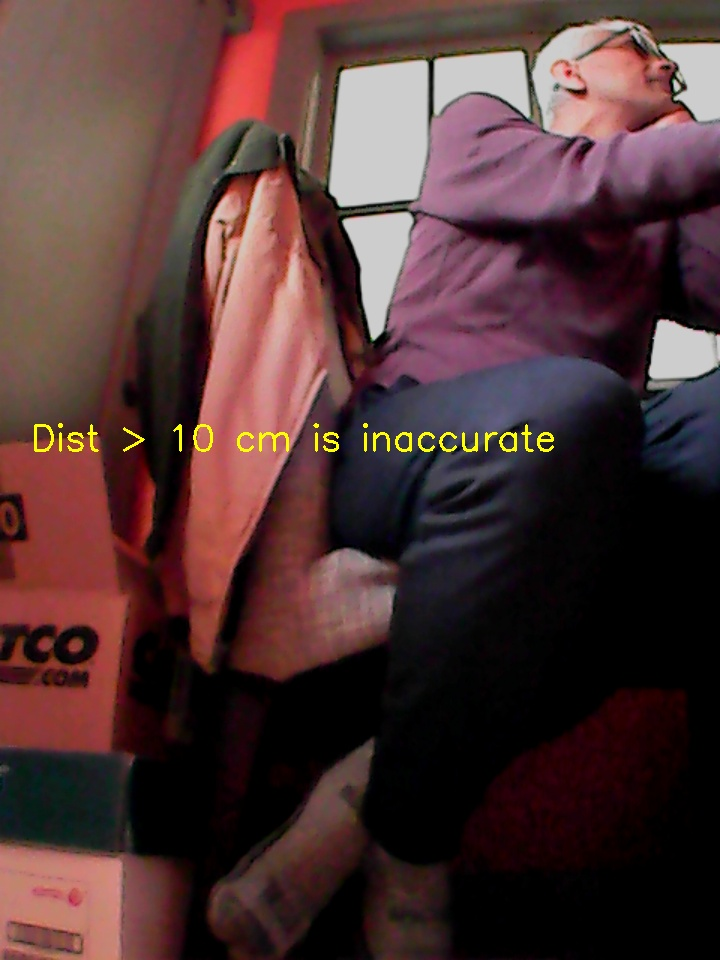

Stopping car...
debug car.set_velocity(0,90,0)
Stopped
debug car.set_velocity(0,90,0)
Released Video Resource from KeyboardInterrupt
Symphony Stopped


In [3]:
speed = 60
old_speed = 0
distance = 9999
Threshold = 50.0
distance_data = []

turn = True
forward = True
stopMotor = True
__isRunning = False

debug = True  # Do not move SnooPi if True
show = True  # Do not show images if False

thread = threading.Thread(target=move)  # Car movement is handled in it's own thread
thread.setDaemon(True)
thread.start()

HWSONAR = Sonar.Sonar()
HWSONAR.startSymphony()


if __name__ == '__main__':
    if debug:
        print("debugging - SnooPi movement is OFF")
    else: 
        print("SnooPi movement is ON!!")
    if show:
        print("SnooPi video is ON!")
    else:
        print("SnooPi video is OFF")
        
    init()     # Initializig globals
    start()    # Start Avoidance thread
    
    computeDist_showVideo()  # Start while loop function to
                             # compute distance using sonar 
                             # and show video if show = True
